In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulation.ThreeCoilSimulation import WoundCoil, ThreeCoilSystem
from simulation.utils import wire_gauge_to_metric, plot_survey_heatmaps, plot_hshp
from simulation.FEMPipeSim import FEMPipe, PipeSimulation
import simulation.LayeredEarthSim

In [2]:
# Define coil parameters
tx_coil = WoundCoil(
    orientation='z',
    position=(0, 0, 0),
    radius=0.125,      # 12.5 cm radius
    turns=40,
    wire_diameter=wire_gauge_to_metric(22), # 20 AWG wire
    resistivity=1.68e-8, # Copper resistivity in ohm-m
    capacitance=1e-14
)

rx_coil = WoundCoil(
    orientation='z',
    position=(1.0, 0, 0),  # 30 cm separation
    radius=0.05,           # 5 cm radius
    turns=50,
    wire_diameter=wire_gauge_to_metric(26), 
    resistivity=1.68e-8,
    capacitance=1e-12
)

bucking_coil = WoundCoil(
    orientation='z',
    position=(0.5, 0, 0),  # Initial guess for optimal position
    radius=0.05,            # 5 cm radius
    turns=5,
    wire_diameter=wire_gauge_to_metric(26),
    resistivity=1.68e-8,
    capacitance=1e-18
)

system = ThreeCoilSystem(tx_coil, rx_coil, bucking_coil, spacing=0.005)

In [3]:
## Find optimal bucking coil position
system.find_bucking_distance(axis='x', bracket=[0.2, 0.9])
print(f"Optimal bucking coil position: {system.bucking_coil.position}")
print(f"Resulting mutual inductance: {system.M_total*1e6:.3f} µH")


Optimal bucking coil position: [0.72314205 0.         0.        ]
Resulting mutual inductance: -0.000 µH


In [3]:
print("TX-coil resistance: {:.4f} Ω".format(tx_coil.resistance))
print("RX-coil resistance: {:.4f} Ω".format(rx_coil.resistance))
print("Bucking-coil resistance: {:.4f} Ω".format(bucking_coil.resistance))

TX-coil resistance: 1.6213 Ω
RX-coil resistance: 2.0496 Ω
Bucking-coil resistance: 0.2050 Ω


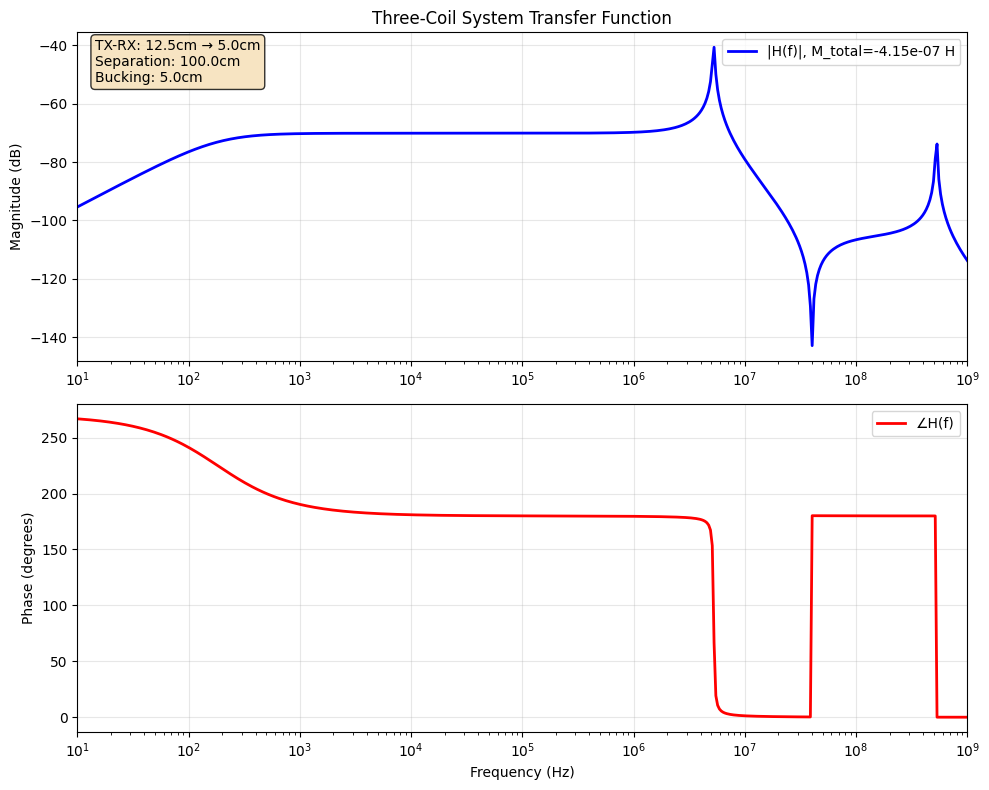

In [4]:
fig = system.plot_transfer_function(frequencies=np.logspace(1, 9, 500))

In [13]:
LayeredEarth = simulation.LayeredEarthSim.LayeredEarthSim(
    layer_thicknesses=[10.0, 10.0], # Two layers
    layer_conductivities=[1e-1, 1e-4, 1e-1], # Conductivities in S/m
    scanner=system
)

frequencies = np.logspace(1, 7, 500)
earth_response = LayeredEarth.simulate(frequencies)

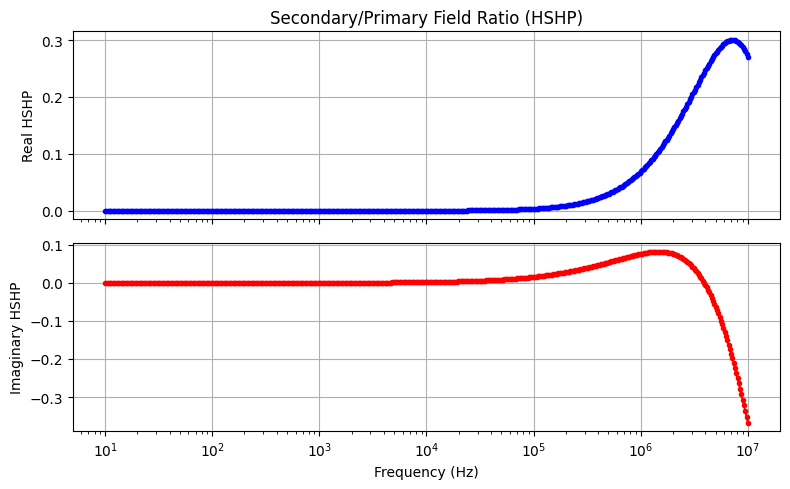

In [14]:
plot_hshp(frequencies, earth_response)

In [15]:
# Define pipe parameters
pipe = FEMPipe(
    length=1.0,          # 1 meter long pipe
    sigma=1.5e6,
    mu_r=1.0,           # Relative permeability
    radius=0.3,          # 10 cm radius
    orientation=np.array([1.0, 0.0, -0.5]), # Aligned along x-axis
    position=(0.0, 0, -0.5), # a bit below the coil system
    n_rings=10
)

# Create simulation
pipe_sim = PipeSimulation(scanner=system, pipes=pipe)
response = pipe_sim.transfer_function(frequencies)

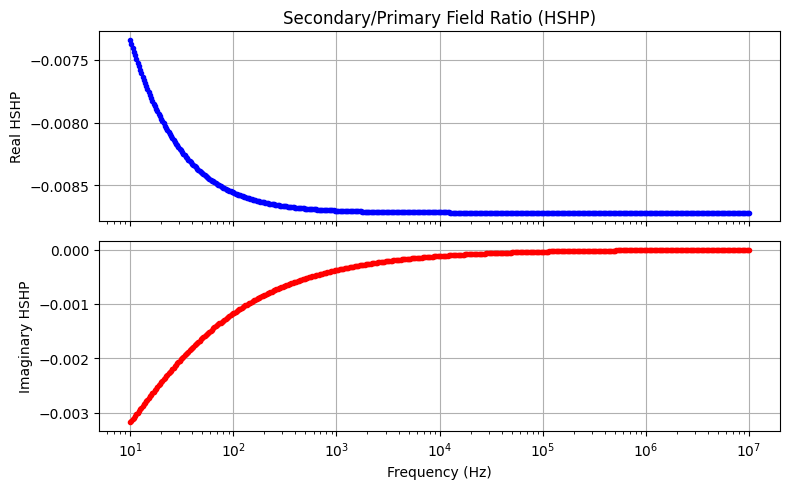

In [10]:
plot_hshp(frequencies, response)

In [8]:
# Generate multiple pipes for survey simulation of a cluster of UXO
num_pipes = 10
pipes = []
np.random.seed(43)
pipe_positions = []
for _ in range(num_pipes):
    length = np.random.uniform(0.2, 1.0)  # Length between 20 cm and 1 m
    sigma = np.random.uniform(1e6, 5e7)   # Conductivity between 1e6 and 5e7 S/m
    radius = np.random.uniform(0.1, 0.4)  # Radius between 2 cm and 10 cm
    position = (
        np.random.uniform(-10.0, 10.0),      # x position
        np.random.uniform(-10.0, 10.0),      # y position
        np.random.uniform(-1.0, 0.0)       # z position (below the coils)
    )
    orientation = np.random.randn(3)
    pipes.append(FEMPipe(
        length=length,
        sigma=sigma,
        mu_r=1.0,
        radius=radius,
        orientation=orientation,
        position=position,
        n_rings=10
    ))
    pipe_positions.append(position)
    

pipe_positions  = np.array(pipe_positions)
# Create survey simulation
busy_survey_sim = PipeSimulation(scanner=system, pipes=pipes)

Running grid search over 100x100 = 10000 points...
Completed 5/100 rows
Completed 10/100 rows
Completed 15/100 rows
Completed 20/100 rows
Completed 25/100 rows
Completed 30/100 rows
Completed 35/100 rows
Completed 40/100 rows
Completed 45/100 rows
Completed 50/100 rows
Completed 55/100 rows
Completed 60/100 rows
Completed 65/100 rows
Completed 70/100 rows
Completed 75/100 rows
Completed 80/100 rows
Completed 85/100 rows
Completed 90/100 rows
Completed 95/100 rows
Completed 100/100 rows


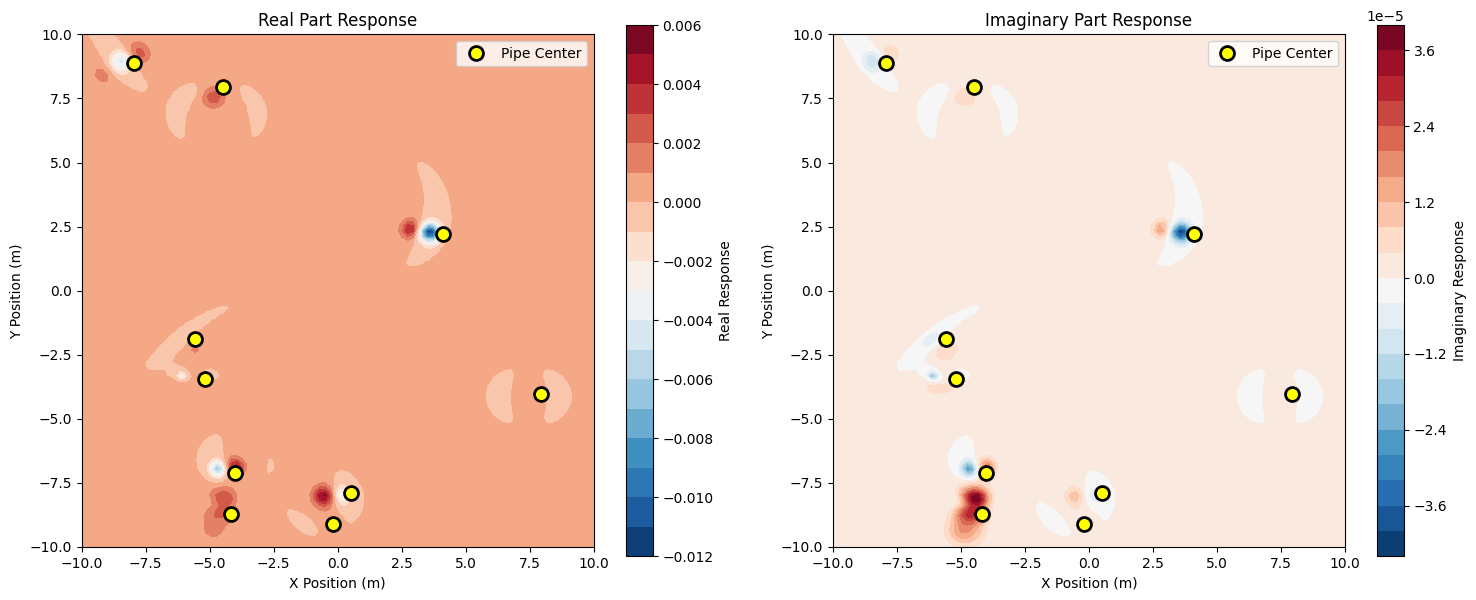

In [9]:
x_grid, y_grid, real_resp, imag_resp = busy_survey_sim.grid_survey(
    x_range=(-10.0, 10.0, 100), 
    y_range=(-10.0, 10.0, 100), 
    z_height=0.2,
    frequencies=np.logspace(3, 5, 100)
)

# Plot the survey results as heat maps
fig, axes = plot_survey_heatmaps(
    x_grid, y_grid, real_resp, imag_resp, 
    pipe_positions=pipe_positions[:, :2],  # Only x,y coordinates for 2D plot
    figsize=(15, 6)
)

